<div class="alert alert-block alert-info">
<b>Deadline:</b> May 11, 2022 (Wednesday) 23:00
</div>


# Exercise 2. Conditional generation with PixelCNN

The goal of this exercise is to do conditional generation with the PixelCNN model.
The basic idea of the conditioning is described in Section 2.3 of [this paper](https://arxiv.org/pdf/1606.05328.pdf). However, we will use a much simpler model.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
device = torch.device('cpu')
if torch.cuda.is_available():
    device = "cuda:0"
print("Running on", device)

Running on cuda:0


In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

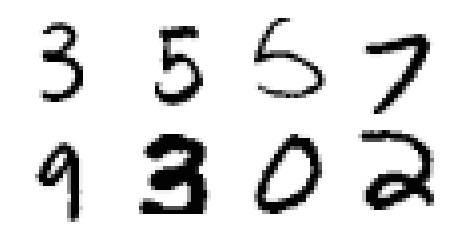

In [8]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Masked convolutional layer

In the cell below, copy the implementation of the `MaskedConv2d` from the PixelCNN notebook.

In [9]:
class MaskedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        """
        Args:
          in_channels (int): Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int): Kernel size similar to nn.Conv2d layer.
          blind_center (bool): If True, the kernel has zero in the center.
        """
        # YOUR CODE HERE
        super(MaskedConv2d, self).__init__()
        self.layer = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = kernel_size,
                               bias = False,
                               padding = int((kernel_size - 1) /2))
        
        self.register_buffer('mask', torch.ones_like(self.layer.weight.data))
        _, _, kH, kW = self.layer.weight.shape
        #print("kH:", kH)
        #print("kW:", kW)
        self.mask[:, :, kH // 2, kW // 2 + (not blind_center):] = 0
        self.mask[:, :, kH // 2 + 1:] = 0
        

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, in_channels, height, width): Input images.
        
        Returns:
          y of shape (batch_size, out_channels, height, width): Output images.
        """
        # YOUR CODE HERE
        self.layer.weight.data *= self.mask
        y = self.layer(x)
        return y

# Conditional PixelCNN

Conditional PixelCNN models allows to generate images of a desired class. This can be achieved by providing the desired class label to every layer of the PixelCNN model. In this notebook, we do it in the following way: the input of each masked convolutional layer is:
$$\mathbf{x} + \mathbf{W} \mathbf{h}$$
where
  * $\mathbf{x}$ is the output of the previous layer
  * $\mathbf{h}$ is a 10-dimensional one-hot coded vector of the desired class
  * $\mathbf{W}$ is $c \times 10$ matrix (parameter of a fully-connected layer), where $c$ is the number of input channels in the masked convolutional layer.

You need to implement the conditional PixelCNN model in the cell below.

Notes:
* Use an architecture *similar* to the PixelCNN architecture in the first notebook. The architecture is not exactly same because of the extra inputs $\mathbf{h}$. Please use the same kernel sizes as in the first notebook because we test the receptive fields.
* The parameters $\mathbf{W}$ are not shared across layers. Thus, you need as many parameters $\mathbf{W}$ as you have masked convolutional layers.

In [10]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        """PixelCNN model for conditional generation."""
        # YOUR CODE HERE
        super(ConditionalPixelCNN, self).__init__()
        
        self.inital =  nn.Sequential(MaskedConv2d(in_channels=1,
                                                  out_channels=n_channels,
                                                  kernel_size=7,
                                                  blind_center=True),
                                     nn.BatchNorm2d(n_channels),
                                     nn.ReLU())
        
        self.fc_init = nn.Linear(in_features = 10, out_features = 1, bias=False)
        
        intermediate_layers_num = 7
        self.intermediate_layers = nn.ModuleList([nn.Sequential(MaskedConv2d(in_channels=n_channels,
                                                               out_channels=n_channels,
                                                               kernel_size=7,
                                                               blind_center=False),
                                                 nn.BatchNorm2d(n_channels),
                                                 nn.ReLU())
                                   for _ in range(intermediate_layers_num)])

        self.fc_intermediate = nn.ModuleList([nn.Linear(in_features = 10, out_features = n_channels, bias=False)
                                for _ in range(intermediate_layers_num)])

        self.final = nn.Conv2d(in_channels=n_channels,
                               out_channels=256,
                               kernel_size=1)
                                  
        self.fc_final = nn.Linear(in_features = 10, out_features = n_channels, bias=False)

        
    def forward(self, x, labels):
        """Compute logits of the conditional probabilities p(x_i|x_1, ..., x_{i-1}) of the PixelCNN model.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Tensor of input images.
          labels of shape (batch_size): Long tensor of the desired classes of the generated samples.
        
        Returns:
          logits of shape (batch_size, 256, 28, 28): Tensor of logits of the conditional probabilities
                                                      for each pixel.
        
        NB: Do not use softmax nonlinearity after the last layer.
        """
        # YOUR CODE HERE
        h = F.one_hot(labels, 10).float()
        Wh = self.fc_init(h).unsqueeze(2).unsqueeze(3)
        y = self.inital(x + Wh)
        
        for i, layer in enumerate(self.intermediate_layers):
            Wh = self.fc_intermediate[0](h).unsqueeze(2).unsqueeze(3)
            y = layer(y + Wh)

        Wh = self.fc_final(h).unsqueeze(2).unsqueeze(3)
        logits = self.final(y + Wh)
        return logits

In [11]:
def test_ConditionalPixelCNN_shapes():
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)

    batch_size = 2
    x = torch.ones(batch_size, 1, 28, 28)
    labels = torch.zeros(batch_size, dtype=torch.long)
    y = net(x, labels)
    assert y.shape == torch.Size([batch_size, 256, 28, 28]), f"Bad y.shape: {y.shape}"
    print('Success')

test_ConditionalPixelCNN_shapes()

Success


### Loss function for training conditional PixelCNN

The `loss_fn()` function is identical to the `loss_fn()` from the PixelCNN notebook.

In [12]:
def loss_fn(logits, x):
    """Compute loss of the conditional PixelCNN model. Please see PixelCNN.loss for more details.

    Args:
      logits of shape (batch_size, 256, 28, 28): Logits of the conditional probabilities
                  p(x_i | x_1,...,x_{i-1}) of the 256 intensities of pixel x_i computed using all
                  previous pixel value x_1,...,x_{i-1}.
      x of shape (batch_size, 1, 28, 28): Images used to produce `generated_x`. The values of pixel
                  intensities in x are between 0 and 1.

    Returns:
      loss: Scalar tensor which contains the value of the loss.
    """
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss()
    x = (x.squeeze()*255).long()
    loss = criterion(logits, x)
    return loss

### Generation procedure

The `generate()` function is *almost* identical to the `generate()` function from the PixelCNN notebook. It additionally receives the labels of the desired classes so that they can be used in the forward computations of the conditional PixelCNN model.

In [13]:
def generate(net, labels, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained conditional PixelCNN model.
    Note: use as device labels.device.

    Args:
      net: Conditional PixelCNN model.
      labels of shape (n_samples): Long tensor of the desired classes of the generated samples.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    with torch.no_grad():
        n_samples = labels.shape[0]
        net.eval()
        samples = torch.zeros(size=(n_samples, 1, image_size[0], image_size[1]),
                              device = device)
        for i in range(image_size[0]):
            for j in range(image_size[1]):
                output = net(samples, labels)
                output_normalized = F.softmax(output, dim=1)
                pixel = torch.multinomial(output_normalized[:,:,i,j],
                                          num_samples=1).float()/255
                samples[:,:,i,j] = pixel
                
    return samples

# Train the model

In [14]:
# Create network
net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
net.to(device)

ConditionalPixelCNN(
  (inital): Sequential(
    (0): MaskedConv2d(
      (layer): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc_init): Linear(in_features=10, out_features=1, bias=False)
  (intermediate_layers): ModuleList(
    (0): Sequential(
      (0): MaskedConv2d(
        (layer): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaskedConv2d(
        (layer): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaskedConv2d(
        (layer): Conv2d(64, 64, kernel_size=(7, 7)

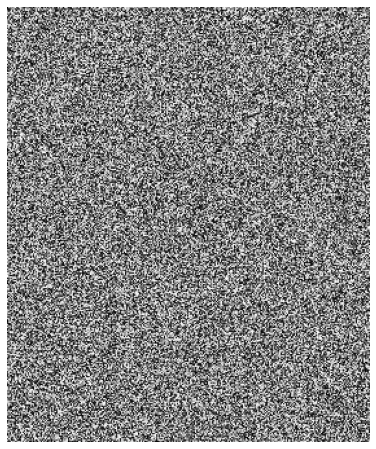

In [15]:
# Plot generated samples for an untrained model
# Note: generation on CPU may take a significant amount of time
if not skip_training:
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 11.

Hints:
- The loss values are similar to the loss values in the PixelCNN notebook.
- Please use this code to plot 120 generated samples after each epoch. This will allow you to track the training progress.
```
# Generate samples
with torch.no_grad():
    net.eval()
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)
```
- The generated images should be of great quality but you should definitely recognize the desired classes of the digits.
- **Do not forget to set the model into the training mode by `net.train()` before training.**

Total:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

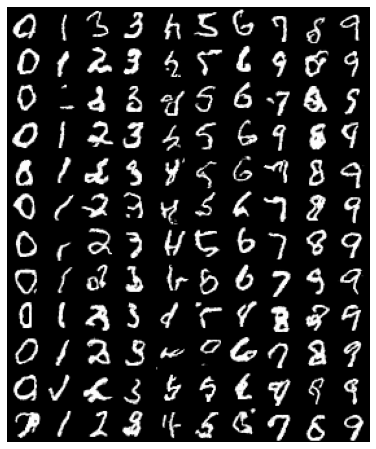

Epoch 1: Average loss is 0.7906
         after 3min 7s


Epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

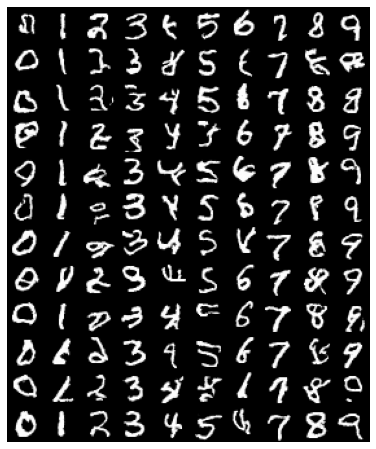

Epoch 2: Average loss is 0.7439
         after 6min 8s


Epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

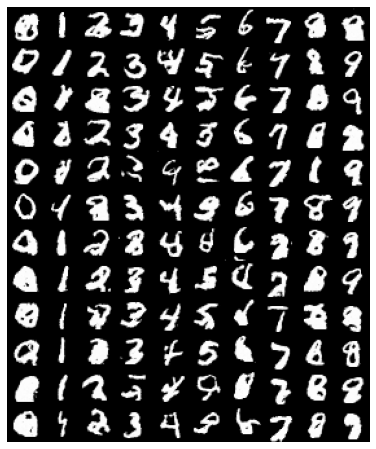

Epoch 3: Average loss is 0.7285
         after 9min 18s


Epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

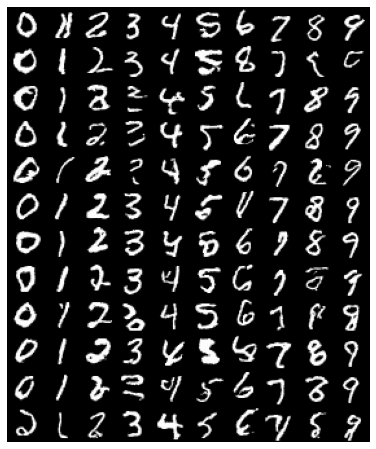

Epoch 4: Average loss is 0.7176
         after 12min 21s


Epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

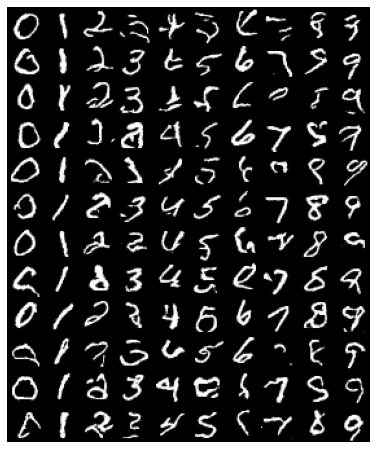

Epoch 5: Average loss is 0.7052
         after 15min 35s


Epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]

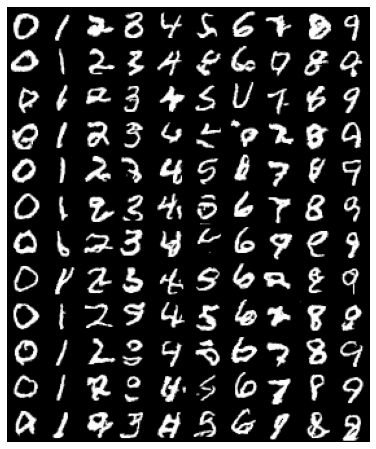

Epoch 6: Average loss is 0.6904
         after 18min 42s


Epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]

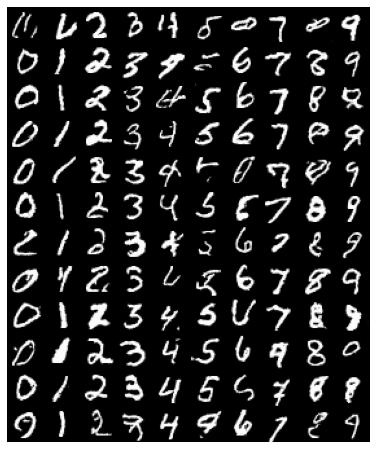

Epoch 7: Average loss is 0.6734
         after 21min 46s


Epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]

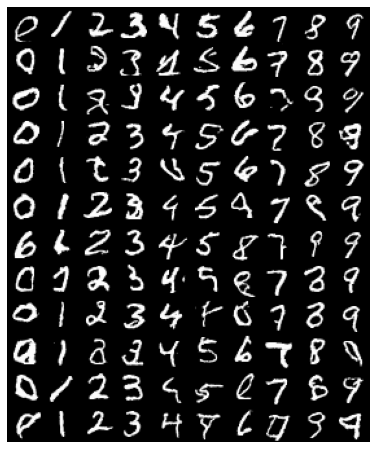

Epoch 8: Average loss is 0.6554
         after 24min 49s


Epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]

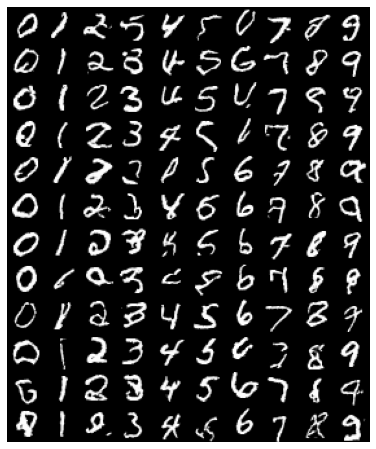

Epoch 9: Average loss is 0.6427
         after 27min 53s


Epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]

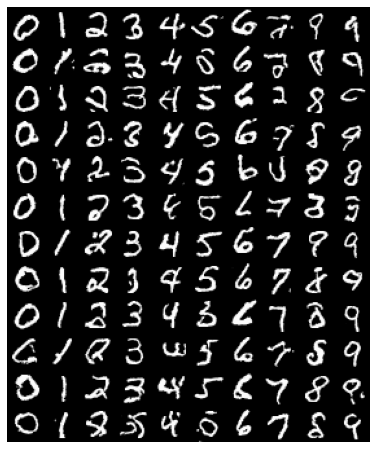

Epoch 10: Average loss is 0.6333
         after 30min 55s


Epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]

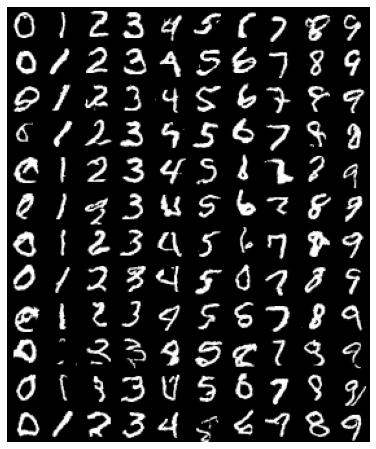

Epoch 11: Average loss is 0.627
         after 33min 55s


In [22]:
if not skip_training:
    import time
    from tqdm.notebook import tqdm
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter()
    #writer.add_graph(net, [images.to(device), labels.to(device)])
    def print_error(epoch, error, total, start):
        current = time.time()
        print(f"Epoch {epoch}: Average loss is {np.round(error/total, decimals = 4)}")
        print(f"         after { int((current - start)/60)}min { int((current - start)%60)}s")

    epochs = 11
    params = net.parameters()
    optimizer = torch.optim.Adam(params, lr=0.001)

    start = time.time()
    epoch_bar = tqdm(range(epochs), total=epochs, desc=f"Total")
    for i in epoch_bar:
      net.train()
      
      error = 0
      total = 0

      batch_bar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {i+1}")
      for j, (images, labels) in batch_bar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = net(images, labels)
            loss = loss_fn(output, images)
            loss.backward()
            optimizer.step()
            error += loss.item()
            total += 1
            writer.add_scalar("Training loss/Running average", loss.item(), i* len(trainloader) + j)
            writer.add_scalar("Training loss/Per batch", error/total, i* len(trainloader) + j)
      with torch.no_grad():
        net.eval()
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        samples = generate(net, labels, device=device)
        tools.plot_generated_samples(samples, ncol=10)
        print_error(i+1, error, total, start)
        
    writer.flush()
    #writer.close()

In [23]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(net, '2_cond_pixelcnn.pth', confirm=True)

Model saved to 2_cond_pixelcnn.pth.


In [24]:
if skip_training:
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
    tools.load_model(net, '2_cond_pixelcnn.pth', device)

### Generate samples

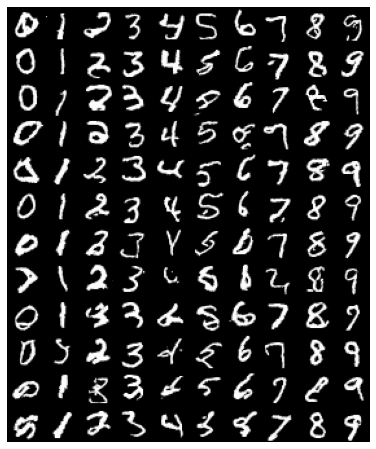

In [25]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        net.eval()
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        samples = generate(net, labels, device=device)
        torch.save(samples, '2_cond_pixelcnn_samples.pth')
else:
    samples = torch.load('2_cond_pixelcnn_samples.pth', map_location=lambda storage, loc: storage)

tools.plot_generated_samples(samples, ncol=10)

In [26]:
# This cell tests the training loss of the trained model

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a conditional PixelCNN model.